In [1]:
from pycocotools.coco import COCO
from pycocoevalcap.eval import COCOEvalCap
import matplotlib.pyplot as plt
import skimage.io as io
import pylab
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

import json
from json import encoder
encoder.FLOAT_REPR = lambda o: format(o, '.3f')
%matplotlib inline

In [2]:
# set up file names and pathes
dataDir='.'
dataType='val2014'
algName = 'fakecap'
annFile='%s/annotations/captions_%s.json'%(dataDir,dataType)
subtypes=['results', 'evalImgs', 'eval']
[resFile, evalImgsFile, evalFile]= \
['%s/results/captions_%s_%s_%s.json'%(dataDir,dataType,algName,subtype) for subtype in subtypes]

# download Stanford models
#!./get_stanford_models.sh

In [3]:
evalFile = './results/captions_val2014_alexcap_eval.json'
evalImgsFile = './results/captions_val2014_alexcap_evalImgs.json'
resFile = './results/captions_val2014_alexcap_results.json'

In [4]:
# create coco object and cocoRes object
coco = COCO(annFile)
cocoRes = coco.loadRes(resFile)

loading annotations into memory...
0:00:00.588986
creating index...
index created!
Loading and preparing results...     
DONE (t=0.52s)
creating index...
index created!


In [5]:
print 'Number of extra images, represented at referense set, but NOT at result set:', len(set(coco.getImgIds())-set(cocoRes.getImgIds()))
print 'Number of extra images, represented at result set, but NOT at referense set:', len(set(cocoRes.getImgIds())-set(coco.getImgIds()))

Number of extra images, represented at referense set, but NOT at result set: 299
Number of extra images, represented at result set, but NOT at referense set: 0


In [6]:
# create cocoEval object by taking coco and cocoRes
cocoEval = COCOEvalCap(coco, cocoRes)

# evaluate on a subset of images by setting
# cocoEval.params['image_id'] = cocoRes.getImgIds()
# please remove this line when evaluating the full validation set
cocoEval.params['image_id'] = cocoRes.getImgIds()

# evaluate results
# SPICE will take a few minutes the first time, but speeds up due to caching
cocoEval.evaluate()

tokenization...
setting up scorers...
computing CIDEr score...
CIDEr: 0.145


In [7]:
# print output evaluation scores
for metric, score in cocoEval.eval.items():
    print '%s: %.3f'%(metric, score)

CIDEr: 0.145


ground truth captions
Two men holding baseball bats on a field. 
there are two baseball players laughing together on the field
Two baseball players in their uniforms holding their bats.
Two young baseball players stand holding their bats.
Two male softball players in blue jerseys standing on a playing field.


generated caption (CIDEr score 0.6)
this man is playing baseball on a field of grass and is holding .
this man is playing baseball on a field of grass and is holding .
this man is playing baseball on a field of grass and is holding .
this man is playing baseball on a field of grass and is holding .
this man is playing baseball on a field of grass and is holding .
this man is playing baseball on a field of grass and is holding .


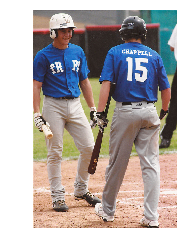

In [12]:
# demo how to use evalImgs to retrieve low score result
imageDir = './udacity_comp_vision/CVND---Image-Captioning-Project/coco_dataset'
evals = [eva for eva in cocoEval.evalImgs if eva['CIDEr']<30]
print 'ground truth captions'
imgId = evals[1003]['image_id']
annIds = coco.getAnnIds(imgIds=imgId)
anns = coco.loadAnns(annIds)
coco.showAnns(anns)

print '\n'
print 'generated caption (CIDEr score %0.1f)'%(evals[0]['CIDEr'])
annIds = cocoRes.getAnnIds(imgIds=imgId)
anns = cocoRes.loadAnns(annIds)
coco.showAnns(anns)

img = coco.loadImgs(imgId)[0]
I = io.imread('%s/images/%s/%s'%(imageDir,dataType,img['file_name']))
plt.imshow(I)
plt.axis('off')
plt.show()

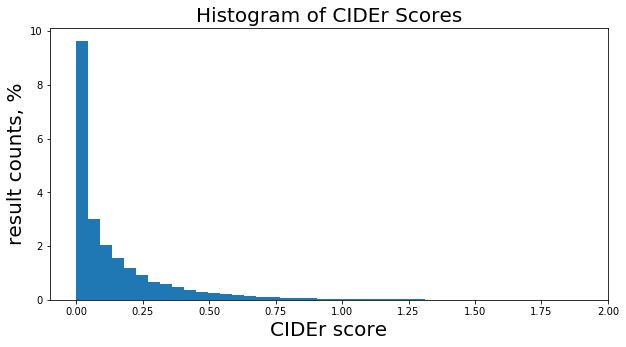

In [13]:
# plot score histogram
plt.rcParams['figure.figsize'] = (10,5)
ciderScores = [eva['CIDEr'] for eva in cocoEval.evalImgs]
plt.hist(ciderScores, bins=100, density=True)
plt.title('Histogram of CIDEr Scores', fontsize=20)
plt.xlabel('CIDEr score', fontsize=20)
plt.xlim(-0.1,2)
plt.ylabel('result counts, %', fontsize=20)
plt.show()

In [14]:
# save evaluation results to ./results folder
json.dump(cocoEval.evalImgs, open(evalImgsFile, 'w'))
json.dump(cocoEval.eval,     open(evalFile, 'w'))